In [1]:
from __future__ import division
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss

sns.set()
import random
import sklearn.externals.joblib as jl
import wfdb
from savvyecg import ecg_utils as eu

pd.options.display.max_columns = 200

%matplotlib inline


/Users/eventura/anaconda/envs/ecg/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Load data

In [2]:
data_dir = '/Users/eventura/physionet.org/physiobank/database/challenge/2011/set-a/'
sample = '1005639'
sig, fields = wfdb.rdsamp(data_dir+sample)

In [3]:
data_signals = dict([(x, y) for x,y in zip(fields['signame'], sig.T)])
fs = fields['fs']

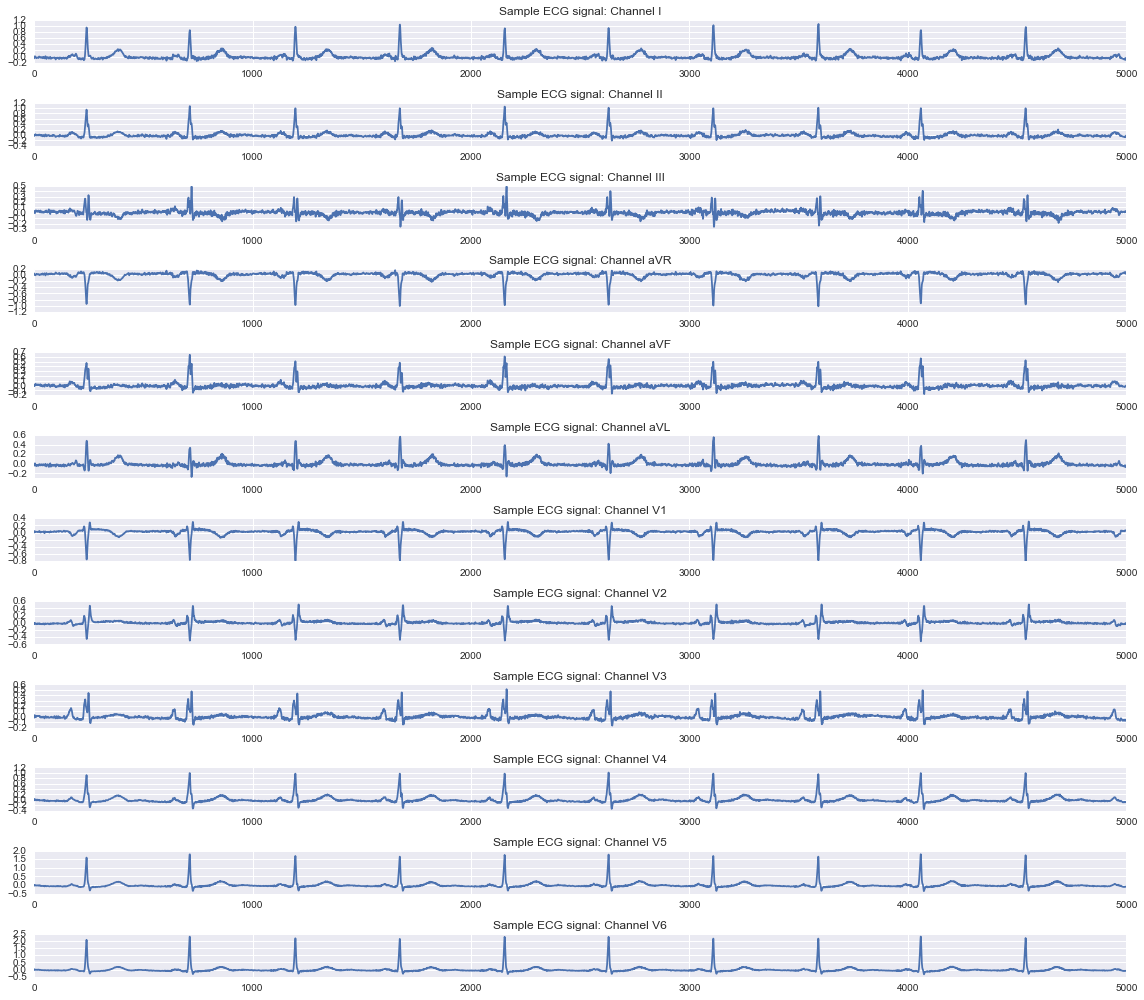

In [4]:
fig, ax = plt.subplots(len(data_signals), figsize = [16, 14])
for i in range(len(data_signals)):
    key = fields['signame'][i]
    ax[i].plot(data_signals[key])
    ax[i].set_title('Sample ECG signal: Channel '+key)
plt.tight_layout()
plt.show()

## Prepare dataframe of an ECG signal

In [5]:
ecg_df = eu.make_ecg_dataframe(data_signals['II'], fs)

## Process ECG signal

In [6]:
ecg_df, rpeaks = eu.process_ecg_df(ecg_df, fs, get_rpeaks=True)

In [7]:
ecg_df.head()

,_time_sec,ecg,processed,r_peak_loc
0,0.000,-0.040,0.015030,0
1,0.002,-0.015,0.028726,0
2,0.004,0.000,0.039903,0
3,0.006,0.000,0.047928,0
4,0.008,0.000,0.054101,0


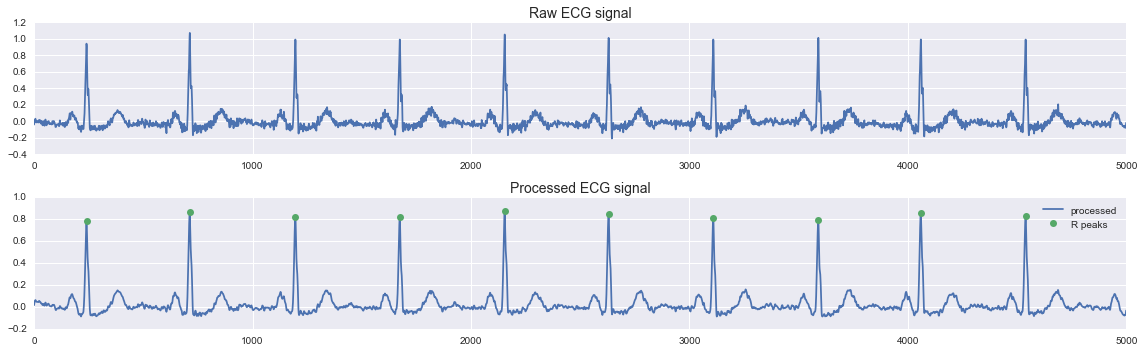

In [8]:
fig, axes = plt.subplots(2, figsize = [16, 5])
ecg_df.ecg.plot(ax=axes[0])
axes[0].set_title('Raw ECG signal', fontsize = 14)
ecg_df.processed.plot(ax=axes[1])
axes[1].plot(rpeaks, ecg_df.processed.ix[rpeaks], 'o', label = 'R peaks')
axes[1].set_title('Processed ECG signal', fontsize = 14)
plt.legend()
plt.tight_layout()
plt.show()